In [1]:
# Importing Necessary Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import h5py
import random
import copy
from PIL import Image
from torchviz import make_dot


In [47]:
# Extracting Data from HDF5 File
file = 'ASLImprovedDataset.hdf5'

# Read Data from HDF5 File
with h5py.File(file, 'r') as df:
    x_train_pre_norm = np.array(df['x_train'])
    y_train_pre_norm = np.array(df['y_train'])
    x_test_pre_norm = np.array(df['x_test'])
    y_test_pre_norm = np.array(df['y_test'])

# Normalize the data
x_train = np.copy(x_train_pre_norm)
x_train = x_train.astype('float32')/255
y_train = np.copy(y_train_pre_norm)

x_test = np.copy(x_test_pre_norm)
x_test = x_test.astype('float32')/255
y_test = np.copy(y_test_pre_norm)


tv_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2,
    #                        saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Extracts Training and Validation Set
class ASLSetTV(torch.utils.data.Dataset):
    def __init__(self, images, labels, forms):
        self.labels = labels
        self.images = images
        self.tform = forms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        lab = self.labels[index]
        X = self.tform(torch.from_numpy(img))
        Y = lab
        return X, Y

# Extracts Test Set
class ASLSetTest(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = self.images[index]
        lab = self.labels[index]
        X = torch.from_numpy(img)
        Y = lab
        return X, Y


classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O','P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# # Split Training Data and Validation Data
# train_to_val_ratio = 0.80
# train_size = int(train_to_val_ratio * len(tv_set))
# val_size = len(tv_set) - train_size
# train_set, val_set = torch.utils.data.random_split(tv_set, [train_size, val_size])


# Load Training and Validation Sets
train_set = ASLSetTV(x_train, y_train, tv_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=False)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size = 100, shuffle = False)


# Load Test Set
test_set = ASLSetTest(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)


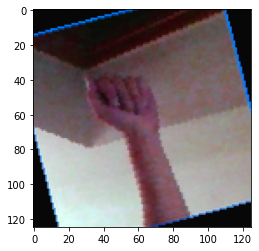

In [68]:
# # import torchvision.transforms.functional as TF
# # Visualize a single image
# for img, label in train_loader:
#     rot = torch.rot90(img, k=1, dims=(1, 2))
#     print(rot.shape, label.shape)
#     print(f'Ground Truth {classes[label[0]]}')
#     plt.imshow(rot[0].permute(2,1, 0))
#     break

batch = next(iter(train_loader))

# Extract the first image from the batch
image = batch[0][0]
rot = torch.rot90(image, k=1, dims=(1, 2))
rot = torch.rot90(rot, k=1, dims=(1, 2))
rot = torch.rot90(rot, k=1, dims=(1, 2))

# Convert the PyTorch tensor to a NumPy array
rot = rot.permute(1, 2, 0).numpy()
# Plot the image using matplotlib
plt.imshow(rot)

# Display the plot
plt.show()

torch.Size([100, 3, 125, 125])
torch.Size([100, 3, 125, 125]) torch.Size([100])
Ground Truth A


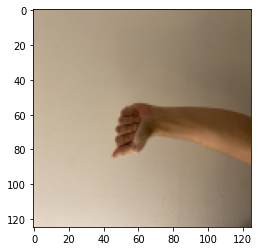

In [6]:
for img, label in test_loader:
    print(img.shape)
    print(img.shape, label.shape)
    print(f'Ground Truth {classes[label[0]]}')
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [7]:
# Custom MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.Linear1 = nn.Linear(3*125*125, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 29)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, x):
        x = x.view(-1, 3*125*125)
        
        # Hidden Layer 1
        x = self.Linear1(x)
        x = nn.ReLU(inplace = True)(x)
        x = self.dropout(x)

        # Hidden Layer 2
        x = self.Linear2(x)
        x = nn.ReLU(inplace = True)(x)
        x = self.dropout(x)

        # Output Layer
        x = self.Linear3(x)
        
        return x

In [8]:
# Custom CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv_layer2 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
        self.conv_layer3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
        self.conv_layer4 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1)

        self.pool_layer = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.bn_layer1 = nn.BatchNorm2d(32)
        self.bn_layer2 = nn.BatchNorm2d(64)
        self.bn_layer3 = nn.BatchNorm2d(128)
        self.bn_layer4 = nn.BatchNorm2d(256)

        self.linear1 = nn.Linear(256 * 7 * 7, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 29)

        self.dropout = nn.Dropout(p = 0.3)

    def forward(self,x):
        # Convolutional Layer 1
        x = self.conv_layer1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool_layer(x)
        x = self.bn_layer1(x)

        # Convolutional Layer 2
        x = self.conv_layer2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool_layer(x)
        x = self.bn_layer2(x)
        
        x = self.dropout(x)
        
        # Convolutional Layer 3
        x = self.conv_layer3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool_layer(x)
        x = self.bn_layer3(x)

        # Convolutional Layer 4
        x = self.conv_layer4(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool_layer(x)
        x = self.bn_layer4(x)
        
        # Linear Layer 1
        x = torch.flatten(x,1)
        x = self.dropout(x)        
        x = self.linear1(x)
        x = nn.ReLU(inplace=True)(x)

        # Linear Layer 2
        x = self.linear2(x)
        x = nn.ReLU(inplace=True)(x)

        # Linear Layer 3
        x = self.linear3(x)
        
        return x



In [9]:
# Plotting Accuracy Curve and Learning Curve
def acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list):
    # Plotting Accuracy
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.arange(num_epochs),train_accuracy_list, label = "Training Data")
    plt.plot(np.arange(num_epochs),val_accuracy_list, label = "Testing Data")
    plt.legend()
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy of Model")
    plt.grid()
    plt.show()

    # Plotting Log-Loss
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.arange(num_epochs),train_loss_list, label = "Training Data")
    plt.plot(np.arange(num_epochs),val_loss_list, label = "Testing Data")
    plt.legend()
    plt.xlabel("Number of Epochs")
    plt.ylabel("Log-Loss")
    plt.title("Learning Curve")
    plt.grid()
    plt.show()

In [10]:
# Creating the Confusion Matrix
def cfm_plotter(gt_label,pred_label):
    plt.rcParams['figure.figsize'] = [10, 10]
    conf_matrix = confusion_matrix(np.array(gt_label), np.array(pred_label))
    width, height = conf_matrix.shape
    plt.figure()
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')

    # Formatting the Confusion Matrix
    plt.xticks(np.arange(width) + 0.5, classes[:width],  rotation=45)
    plt.yticks(np.arange(height) + 0.5, classes[:height], rotation='horizontal')
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title('Confusion Matrix')
    plt.show()


In [26]:
# Model definition
def overall_model(model_variation, learning_rate, L2_coeff, num_epochs):
    # Speed Up Training Time with MPS
    device = torch.device('mps' if torch.has_mps else 'cpu')
    print(f"Using device: {device}")


    ## Choosing which model to run
    # Custom MLP
    if (model_variation == "MLP"):
        model = MLP()
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = L2_coeff)

    # Custon CNN
    if (model_variation == "CNN"):
        model = CNN()
        optimizer = torch.optim.NAdam(model.parameters(), lr = learning_rate, weight_decay = L2_coeff)
        
    # Resnet18
    if (model_variation == "resnet"):
        model = models.resnet18()
        model.fc = nn.Linear(model.fc.in_features, 29)  # use this for resnet
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = L2_coeff)

    # MobileNetV2
    if (model_variation == "mobilenet"): 
        model = models.mobilenet_v2()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = L2_coeff)

    # SqueezeNet
    if (model_variation == "squeezenet"): 
        model = models.squeezenet1_0()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = L2_coeff)


    # Set Up Model
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = [], [], [], []
    overall_total = len(train_loader)
    min_loss = np.Inf
    
    # Training and Testing the Model
    for epoch in range(num_epochs):
        train_loss, train_acc, train_total = 0, 0, 0
        start_time = time()

        # Training Mode
        model.train()
        for images_train, labels_train in tqdm(train_loader, desc = 'Training Set', unit = 'Batches'):
            # Moving to MPS
            images_train = images_train.to(device)
            labels_train = labels_train.to(device)

            # Forward Inference
            optimizer.zero_grad()
            outputs_train = model(images_train)
            # make_dot(outputs_train, params = dict(model.named_parameters())).render(model_variation, format = "png")
            loss = criterion(outputs_train, labels_train)

            # Backward Propagation
            loss.backward()
            optimizer.step()

            # Calculate Mtrics
            train_loss += loss.item()
            _,pred = torch.max(outputs_train, dim = 1)
            train_acc += torch.sum(pred == labels_train).item()
            train_total += labels_train.size(0)

        # Prep for Plotting
        train_accuracy_list.append(100 * train_acc / train_total)
        train_loss_list.append(train_loss/ overall_total)
        
        #Validation/Testing  
        val_loss, val_acc, val_total = 0, 0, 0
        with torch.no_grad():
            model.eval()
            y_true = []
            y_pred = []
            for images_val, labels_val in tqdm(test_loader, desc = 'Validation Set', unit = 'Batches'):
                # Moving to MPS
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)

                # Forward Inference
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)

                # Calculate Metrics
                val_loss += loss_val.item() 
                _,pred_val = torch.max(outputs_val, dim = 1)
                val_acc += torch.sum(pred_val == labels_val).item()
                val_total += labels_val.size(0)

                # For Confusion Matrix
                _, predicted = torch.max(outputs_val.data, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels_val.cpu().numpy())
                

            # Prep for Plotting
            val_accuracy_list.append(100 * val_acc / val_total)
            val_loss_list.append(val_loss / len(test_loader))
            checkpoint = val_loss < min_loss

            print(f"[{epoch+1}/{num_epochs}], Training Accuracy: {100 * train_acc/train_total:.4f}%, Testing Accuracy: {100 * val_acc/val_total:.4f}%, " + 
            f" Training Loss: {np.mean(train_loss_list):.4f}, Test loss: {np.mean(val_loss_list):.4f}. Time per epoch: {(time() - start_time):.2} seconds")
            iter_time = time()

            if checkpoint:
                min_loss = val_loss
                if (model_variation == 'MLP'):
                    torch.save(model.state_dict(), 'MLP.pt')
                if (model_variation == 'CNN'):
                    torch.save(model.state_dict(), 'CNN.pt')
                if (model_variation == 'resnet'):
                    torch.save(model.state_dict(), 'resnet.pt')
                if (model_variation == 'mobilenet'):
                    torch.save(model.state_dict(), 'mobilenet.pt')
                if (model_variation == 'squeezenet'):
                    torch.save(model.state_dict(), 'squeezenet.pt')

    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, y_pred, y_true

In [ ]:
# # Custom MLP Network

# learning_rate = 5e-4
# L2_coeff = 1e-4
# num_epochs = 5
# model_variation = "MLP"

# train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, predicted_label, gt_label = overall_model(model_variation, learning_rate, L2_coeff, num_epochs)


In [13]:
# # Plot Accuracy, Learning Curve, and Confusion Matrix for Custom MLP

# acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list)
# cfm_plotter(gt_label,predicted_label)


In [ ]:
# # Custom CNN Network

# learning_rate = 1e-3
# L2_coeff = 5e-4
# num_epochs = 3
# model_variation = "CNN"

# train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, predicted_label, gt_label = overall_model(model_variation, learning_rate, L2_coeff, num_epochs)


In [15]:
# # Plot Accuracy, Learning Curve, and Confusion Matrix for Custom CNN

# acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list)
# cfm_plotter(gt_label,predicted_label)



In [ ]:
# # ResNet18 Network

# learning_rate = 5e-4
# L2_coeff = 1e-4
# num_epochs = 10
# model_variation = "resnet"

# train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, predicted_label, gt_label = overall_model(model_variation, learning_rate, L2_coeff, num_epochs)


In [17]:
# # Plot Accuracy, Learning Curve, and Confusion Matrix for ResNet18

# acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list)
# cfm_plotter(gt_label,predicted_label)



In [ ]:
# # MobileNetV2 Network

# learning_rate = 5e-4
# L2_coeff = 1e-4
# num_epochs = 10
# model_variation = "mobilenet"

# train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, predicted_label, gt_label = overall_model(model_variation, learning_rate, L2_coeff, num_epochs)


In [ ]:
# # Plot Accuracy, Learning Curve, and Confusion Matrix for MobileNetV2

# acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list)
# cfm_plotter(gt_label,predicted_label)


In [ ]:
# # SqueezeNet Network

# learning_rate = 5e-4
# L2_coeff = 1e-4
# num_epochs = 1
# model_variation = "squeezenet"

# train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list, predicted_label, gt_label = overall_model(model_variation, learning_rate, L2_coeff, num_epochs)


In [ ]:
# # Plot Accuracy, Learning Curve, and Confusion Matrix for SqueezeNet

# acc_LC_plotter(train_accuracy_list,val_accuracy_list,train_loss_list,val_loss_list)
# cfm_plotter(gt_label,predicted_label)
